In [ ]:
## Project: Liver Disease Classification Using Machine Learning

"""
This notebook contains all code used to preprocess the Indian Liver Patient Dataset (ILPD), train multiple machine learning models, 
evaluate their performance, and visualize results. The goal is to compare different classification methods and understand which 
techniques work best on this small, imbalanced medical dataset.
"""

In [1]:
#import libraries we will use
# ============================================

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

# Scikit-learn tools for splitting, preprocessing, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Eval metrics 
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

#Make plots look a bit nicer 
plt.style.use("default")
sns.set(font_scale=1.1)


In [ ]:
## Loading the Dataset

"""
The ILPD file from UCI has no header row, so column names are manually assigned. This step loads the dataset into a Pandas DataFrame 
for preprocessing.
"""

In [2]:
csv_path = "../data/ILPD.csv"

#ILPD column names:
column_names = [
    'Age',
    'Gender',
    'Total_Bilirubin',
    'Direct_Bilirubin',
    'Alkaline_Phosphotase',
    'Alamine_Aminotransferase',
    'Aspartate_Aminotransferase',
    'Total_Protiens',
    'Albumin',
    'Albumin_and_Globulin_Ratio',
    'Dataset'
]
                
df = pd.read_csv(csv_path, header=None, names=column_names)

print("Shape of dataset:", df.shape)
display(df.head())

print("\nColumn names:")
print(df.columns.tolist())

Shape of dataset: (583, 11)


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1



Column names:
['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Dataset']


In [ ]:
## Encoding Gender and Recoding Target Variable

"""
• The target column uses labels 1/2. We convert this to 1/0 for binary classification.
• Gender is encoded as 1 = Male and 0 = Female.

These encodings simplify modeling and match typical ML preprocessing steps.
"""

In [3]:
# 1 = liver disease, 2 = no disease 
# we want: 1 --> 1 (positive case), 2 --> 0 (negative class)
df["Dataset"] = df["Dataset"].map({1: 1, 2: 0})

# Encode Gender as a binary indicator: Male = 1, Female = 0
df["Gender"] = (df["Gender"] == "Male").astype(int)

# Checkpoint
print("Target value count (after recoring):")
print(df["Dataset"].value_counts())

print("Target value proportions:")
print(df["Dataset"].value_counts(normalize=True))

print("\nGender value counts (after encoding):")
print(df["Gender"].value_counts())

Target value count (after recoring):
Dataset
1    416
0    167
Name: count, dtype: int64
Target value proportions:
Dataset
1    0.713551
0    0.286449
Name: proportion, dtype: float64

Gender value counts (after encoding):
Gender
1    441
0    142
Name: count, dtype: int64


In [ ]:
## Handling Missing Values

"""
There are a few missing entries in the Albumin/Globulin ratio column. Since the dataset is small and missingness is minimal, I remove rows 
with missing values to avoid introducing noise through imputation.
"""

In [4]:
print("Missing values per column BEFORE drop:")
print(df.isna().sum())

#Drop any rows with missing values
df = df.dropna()

print("\nMissing values per column AFTER drop:")
print(df.isna().sum())

Missing values per column BEFORE drop:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

Missing values per column AFTER drop:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


In [ ]:
## Defining Features (X) and Labels (y)

# The dataset contains 10 biochemical and demographic features. The “Dataset” column is the label (0/1), representing liver disease status.

In [5]:
# X = all feature columns except the target
X = df.drop("Dataset", axis=1)

# y = target label (0 or 1)
y = df["Dataset"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

print("\nFeature columns:")
print(X.columns.tolist())

print("\nTarget value distribution:")
print(y.value_counts(normalize=True))

Feature shape: (579, 10)
Target shape: (579,)

Feature columns:
['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

Target value distribution:
Dataset
1    0.715026
0    0.284974
Name: proportion, dtype: float64


In [ ]:
## Splitting Data into Train, Validation, and Test Sets

"""
I use a 70/15/15 split with stratification to keep class proportions consistent. The validation set will be used for tuning model 
hyperparameters, while the test set is held out for final evaluation.
"""

In [6]:
# 1) First split: train_val(85%) vs test(15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# 2) Second split: train (70%) vs validation (~15%)
# Compute exact val ratio inside the train_val portion 
val_ratio = 0.15/0.85 # ≈ 0.176

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_ratio,
    random_state=42,
    stratify=y_train_val
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

print("\nTraining class distribution:")
print(y_val.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train shape: (405, 10)
Validation shape: (87, 10)
Test shape: (87, 10)

Training class distribution:
Dataset
1    0.712644
0    0.287356
Name: proportion, dtype: float64

Test class distribution:
Dataset
1    0.712644
0    0.287356
Name: proportion, dtype: float64


In [ ]:
## Feature Scaling (Standardization)

"""
Standardization is important for models that rely on distances or gradient-based optimization (Logistic Regression, KNN, Neural Network).
Tree-based models do not require scaling, but for consistency I store both scaled and unscaled versions.
"""

In [7]:
# Create the scaler
scaler = StandardScaler()

# Fit ONLY on the training features (very important to avoid data leakage!)
scaler.fit(X_train)

# Transform training, validation, and test sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Shapes confirm nothing changed except scaling 
print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_val shape:", X_val_scaled.shape)
print("Scaled X_test shape:", X_test_scaled.shape)

# Show a small preview of scaled values (first row only)
print("\nPreview of a scaled sample:")
print(X_train_scaled[0])

Scaled X_train shape: (405, 10)
Scaled X_val shape: (87, 10)
Scaled X_test shape: (87, 10)

Preview of a scaled sample:
[ 0.52884501  0.55738641 -0.40453808 -0.37620266 -0.22174867 -0.34599822
 -0.40273048  0.08925325 -0.33393776 -0.48923028]


In [ ]:
## Evaluation Helper Function

"""
To avoid repetitive code, I define a function that trains a model and prints Accuracy, Precision, Recall, F1, ROC-AUC, and PR-AUC.
These metrics are especially relevant because of the dataset’s class imbalance.
"""

In [8]:
from sklearn.preprocessing import MinMaxScaler  # used only if we need to rescale decision_function outputs

def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, model_name="Model"):
    """
    Fit a classifier on (X_tr, y_tr), evaluate on (X_te, y_te),
    print metrics, and return them as a dict.
    
    Parameters
    ---------------------------------------------------------------------------------------------
    model : sklearn-like classifier (has fit, predict, possibly predict_proba/decision_function)
    X_tr, y_tr : training data and labels
    X_te, y_te : test data and labels
    model_name : string used for printing
    
    Returns
    ---------------------------------------------------------------------------------------------
    metrics : dict with accuracy, precision, recall, f1, roc_auc, pr_auc
    """

    # ---- Train the model -----
    model.fit(X_tr, y_tr)

    # ---- Get class predictions (0 or 1) ----
    y_pred = model.predict(X_te)
    
    # ---- Get predicted probabilities for the positive class (needed for ROC/PR curves) ----
    if hasattr(model, "predict_proba"):
        # Many classifiers implement predict_proba (LogReg, RF, XGB, etc.)
        y_proba = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        # Some (like SVM) use decision_function instead
        scores = model.decision_function(X_te)
        # Scale scores to [0, 1] so we can treat them like probabilities
        tmp_scaler = MinMaxScaler()
        y_proba = tmp_scaler.fit_transform(scores.reshape(-1, 1)).ravel()
    else:
        # Fallback: use predictions as "probabilities" (not ideal, but rarely needed)
        y_proba = y_pred.astype(float)

    # ---- Compute metrics ----
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec  = recall_score(y_te, y_pred, zero_division=0)
    f1   = f1_score(y_te, y_pred, zero_division=0)
    roc  = roc_auc_score(y_te, y_proba)
    
    # Precision-Recall curve → PR-AUC (area under precision vs recall)
    prec_curve, rec_curve, _ = precision_recall_curve(y_te, y_proba)
    
    # Sort recall in ascending order before computing area
    rec_sorted_idx = np.argsort(rec_curve)
    pr_auc = np.trapz(prec_curve[rec_sorted_idx], rec_curve[rec_sorted_idx])
    
    # ---- Print nicely ----
    print(f"\n=== {model_name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print(f"ROC-AUC  : {roc:.3f}")
    print(f"PR-AUC   : {pr_auc:.3f}")

    # ---- Return metrics as dict ----
    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }

In [ ]:
## Logistic Regression (Baseline Model)

"""
This is the baseline classifier.
It provides a good reference point because it is simple, interpretable, and performs surprisingly well on this dataset.

Key expectation:
High recall (medical setting) and stable ROC-AUC.
"""

In [9]:
from sklearn.linear_model import LogisticRegression

# Create the logistic regression model 
# - 'liblinear' solver works well for small binary datasets
# - C is inverse of regularization strength (smaller C = stronger regularization)
log_reg = LogisticRegression(
    solver="liblinear",
    C=1.0,
    random_state=42
)

# Evaluate on the TEST set using scaled features
log_reg_results = evaluate_classifier(
    model=log_reg,
    X_tr=X_train_scaled,
    y_tr=y_train,
    X_te=X_test_scaled,
    y_te=y_test,
    model_name="Logistic Regression"
)

log_reg_results


=== Logistic Regression ===
Accuracy : 0.736
Precision: 0.747
Recall   : 0.952
F1-score : 0.837
ROC-AUC  : 0.803
PR-AUC   : 0.918


{'model': 'Logistic Regression',
 'accuracy': 0.735632183908046,
 'precision': 0.7468354430379747,
 'recall': 0.9516129032258065,
 'f1': 0.8368794326241135,
 'roc_auc': 0.8025806451612904,
 'pr_auc': 0.9181277709964621}

In [ ]:
## K-Nearest Neighbors (KNN)

"""
KNN relies on distance, so scaling is essential.
Because the dataset is small and noisy, I expect KNN to perform worse than Logistic Regression.
"""

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Try K=5 as a starting point 
knn = KNeighborsClassifier(n_neighbors=5)

# Evaluate using the scaled features 
knn_results = evaluate_classifier(
    model=knn,
    X_tr=X_train_scaled,
    y_tr=y_train,
    X_te=X_test_scaled,
    y_te=y_test,
    model_name="KNN (k=5)"
)

knn_results


=== KNN (k=5) ===
Accuracy : 0.701
Precision: 0.750
Recall   : 0.871
F1-score : 0.806
ROC-AUC  : 0.591
PR-AUC   : 0.806


{'model': 'KNN (k=5)',
 'accuracy': 0.7011494252873564,
 'precision': 0.75,
 'recall': 0.8709677419354839,
 'f1': 0.8059701492537313,
 'roc_auc': 0.5909677419354838,
 'pr_auc': 0.806212717262678}

In [ ]:
## Decision Tree

"""
Decision Trees can model nonlinear relationships but tend to overfit small datasets.
Setting a max depth helps control overfitting, but I still expect instability.
"""

In [11]:
from sklearn.tree import DecisionTreeClassifier

# We'll set a small max_depth at first to prevent extreme overfitting
decision_tree = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

dt_results = evaluate_classifier(
    model=decision_tree,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
    model_name="Decision Tree (max_depth=5)"
)

dt_results


=== Decision Tree (max_depth=5) ===
Accuracy : 0.690
Precision: 0.711
Recall   : 0.952
F1-score : 0.814
ROC-AUC  : 0.714
PR-AUC   : 0.889


{'model': 'Decision Tree (max_depth=5)',
 'accuracy': 0.6896551724137931,
 'precision': 0.7108433734939759,
 'recall': 0.9516129032258065,
 'f1': 0.8137931034482758,
 'roc_auc': 0.7138709677419354,
 'pr_auc': 0.8888472116119285}

In [ ]:
## Random Forest

"""
Random Forest reduces the variance of a single tree by averaging many trees.
I expect more stable and stronger performance than the Decision Tree.
"""

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # fully grown trees (RF handles overfitting better)
    random_state=42
)

rf_results = evaluate_classifier(
    model=rf,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
    model_name="Random Forest"
)

rf_results


=== Random Forest ===
Accuracy : 0.736
Precision: 0.747
Recall   : 0.952
F1-score : 0.837
ROC-AUC  : 0.775
PR-AUC   : 0.908


{'model': 'Random Forest',
 'accuracy': 0.735632183908046,
 'precision': 0.7468354430379747,
 'recall': 0.9516129032258065,
 'f1': 0.8368794326241135,
 'roc_auc': 0.7751612903225806,
 'pr_auc': 0.9075543870266035}

In [13]:
# installing/importing XGBoost
import sys
print(sys.executable)

# Install xgboost into the same environment Jupyter is using
!{sys.executable} -m pip install xgboost

/opt/anaconda3/envs/tf-class/bin/python


In [ ]:
## Gradient Boosting (Boosting Model)

"""
Boosting builds trees sequentially, correcting previous mistakes.
Week 10 covered boosting concepts, and scikit-learn’s implementation fits within course expectations.
"""

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,    # number of boosting rounds
    learning_rate=0.05,  # similar to XGBoost's learning rate
    max_depth=3,         # depth of individual trees
    random_state=42
)

gb_results = evaluate_classifier(
    model=gb,
    X_tr=X_train,
    y_tr=y_train,
    X_te=X_test,
    y_te=y_test,
    model_name="Gradient Boosting"
)

gb_results


=== Gradient Boosting ===
Accuracy : 0.724
Precision: 0.744
Recall   : 0.935
F1-score : 0.829
ROC-AUC  : 0.751
PR-AUC   : 0.900


{'model': 'Gradient Boosting',
 'accuracy': 0.7241379310344828,
 'precision': 0.7435897435897436,
 'recall': 0.9354838709677419,
 'f1': 0.8285714285714286,
 'roc_auc': 0.7509677419354838,
 'pr_auc': 0.8997902066097591}

In [ ]:
## Neural Network (MLP)

"""
A small feed-forward neural network is used to model nonlinear interactions.
Because the dataset is small, I include dropout and validation to avoid overfitting.
"""

In [15]:
# Note: will take a bit to load
# ============================================

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the model
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])

# Compile the model
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with validation data
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=16,
    verbose=0 
)

# For evaluation we use model.predict to get probabilities
y_proba_nn = nn_model.predict(X_test_scaled).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

# Compute metrics
nn_results = {
    "model": "Neural Network",
    "accuracy": accuracy_score(y_test, y_pred_nn),
    "precision": precision_score(y_test, y_pred_nn, zero_division=0),
    "recall": recall_score(y_test, y_pred_nn, zero_division=0),
    "f1": f1_score(y_test, y_pred_nn, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba_nn)
}

# PR-AUC
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba_nn)
rec_sorted_idx = np.argsort(rec_curve)
nn_results["pr_auc"] = np.trapz(
    prec_curve[rec_sorted_idx],
    rec_curve[rec_sorted_idx]
)

# Print
print("\n=== Neural Network (MLP) ===")
for k, v in nn_results.items():
    if k != "model":
        print(f"{k.capitalize():<10}: {v:.3f}")

nn_results

/opt/anaconda3/envs/tf-class/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-06 21:54:14.841696: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-06 21:54:14.841841: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-06 21:54:14.841848: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-06 21:54:14.842094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-06 21:54:14.842106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Create

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

=== Neural Network (MLP) ===
Accuracy  : 0.736
Precision : 0.747
Recall    : 0.952
F1        : 0.837
Roc_auc   : 0.805
Pr_auc    : 0.921


{'model': 'Neural Network',
 'accuracy': 0.735632183908046,
 'precision': 0.7468354430379747,
 'recall': 0.9516129032258065,
 'f1': 0.8368794326241135,
 'roc_auc': 0.804516129032258,
 'pr_auc': 0.9210886032861019}

In [ ]:
## Autoencoder for Dimensionality Reduction

"""
The autoencoder compresses the 10-dimensional input into a 3-dimensional latent representation.
This is exploratory and follows Week 12’s discussion on learned feature extraction.
"""

In [16]:
# Note: will take a bit to load
# ============================================

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

# --- Build Autoencoder ---

# Input layer: number of features = X_train_scaled.shape[1]
input_layer = Input(shape=(X_train_scaled.shape[1],))

# Encoder: compress to 6 units → then 3 units (latent space)
encoded = Dense(6, activation='relu')(input_layer)
latent = Dense(3, activation='relu', name="latent_layer")(encoded)

# Decoder: reconstruct back to 6 → 10
decoded = Dense(6, activation='relu')(latent)
output_layer = Dense(X_train_scaled.shape[1], activation='linear')(decoded)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(
    optimizer='adam',
    loss='mse'
)

# Train autoencoder (quiet, small epochs)
history_ae = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=50,
    batch_size=16,
    verbose=0
)

print("Autoencoder training complete.")

Autoencoder training complete.


In [ ]:
## Logistic Regression on Autoencoder Latent Features

"""
This tests whether the compressed representation is useful for classification.
I expect lower performance than Logistic Regression on the original features.
"""

In [17]:
# Build encoder model: takes input --> outputs the latent 3D vector
encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent_layer").output
)

# Generate latent features for train, val, test
X_train_latent = encoder.predict(X_train_scaled)
X_val_latent   = encoder.predict(X_val_scaled)
X_test_latent  = encoder.predict(X_test_scaled)

print("Latent shapes:")
print("Train latent:", X_train_latent.shape)
print("Val latent:  ", X_val_latent.shape)
print("Test latent: ", X_test_latent.shape)

# Train logistic regression on the 3D latent representation
log_reg_latent = LogisticRegression(
    solver="liblinear",
    C=1.0,
    random_state=42
)

log_reg_latent_results = evaluate_classifier(
    model=log_reg_latent,
    X_tr=X_train_latent,
    y_tr=y_train,
    X_te=X_test_latent,
    y_te=y_test,
    model_name="Logistic Regression (Autoencoder Latent Space)"
)

log_reg_latent_results

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Latent shapes:
Train latent: (405, 3)
Val latent:   (87, 3)
Test latent:  (87, 3)

=== Logistic Regression (Autoencoder Latent Space) ===
Accuracy : 0.747
Precision: 0.744
Recall   : 0.984
F1-score : 0.847
ROC-AUC  : 0.763
PR-AUC   : 0.900


{'model': 'Logistic Regression (Autoencoder Latent Space)',
 'accuracy': 0.7471264367816092,
 'precision': 0.7439024390243902,
 'recall': 0.9838709677419355,
 'f1': 0.8472222222222222,
 'roc_auc': 0.7625806451612904,
 'pr_auc': 0.9002958815315153}

In [ ]:
## Preparing ROC and PR Curves for All Models

"""
To compare classifier performance visually, I compute ROC and PR curves for each model.
These combined plots give an overview of each model’s strengths.
"""

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve

models_curves = {}

# Helper to compute ROC/PR curves and store them
def get_curves_and_auc(y_true, y_proba):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    # PR curve
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    # Sort recall for correct PR-AUC integration
    rec_sorted_idx = np.argsort(rec)
    pr_auc = np.trapz(prec[rec_sorted_idx], rec[rec_sorted_idx])
    
    return {
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "precision": prec,
        "recall": rec,
        "pr_auc": pr_auc
    }

# 1) Logistic Regression (scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
models_curves["Logistic Regression"] = get_curves_and_auc(y_test, y_proba_lr)

# 2) KNN (scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]
models_curves["KNN (k=5)"] = get_curves_and_auc(y_test, y_proba_knn)

# 3) Decision Tree (unscaled)
y_proba_dt = decision_tree.predict_proba(X_test)[:, 1]
models_curves["Decision Tree"] = get_curves_and_auc(y_test, y_proba_dt)

# 4) Random Forest (unscaled)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
models_curves["Random Forest"] = get_curves_and_auc(y_test, y_proba_rf)

# 5) Gradient Boosting (unscaled)
y_proba_gb = gb.predict_proba(X_test)[:, 1]
models_curves["Gradient Boosting"] = get_curves_and_auc(y_test, y_proba_gb)

# 6) Neural Network (we already have probabilities y_proba_nn)
models_curves["Neural Network"] = get_curves_and_auc(y_test, y_proba_nn)

# 7) Logistic Regression on Autoencoder latent space
y_proba_latent = log_reg_latent.predict_proba(X_test_latent)[:, 1]
models_curves["LogReg (Latent Space)"] = get_curves_and_auc(y_test, y_proba_latent)

print("Stored curves for models:")
for name, info in models_curves.items():
    print(f"- {name}: ROC-AUC = {info['roc_auc']:.3f}, PR-AUC = {info['pr_auc']:.3f}")

Stored curves for models:
- Logistic Regression: ROC-AUC = 0.803, PR-AUC = 0.918
- KNN (k=5): ROC-AUC = 0.591, PR-AUC = 0.806
- Decision Tree: ROC-AUC = 0.714, PR-AUC = 0.889
- Random Forest: ROC-AUC = 0.775, PR-AUC = 0.908
- Gradient Boosting: ROC-AUC = 0.751, PR-AUC = 0.900
- Neural Network: ROC-AUC = 0.805, PR-AUC = 0.921
- LogReg (Latent Space): ROC-AUC = 0.763, PR-AUC = 0.900


In [ ]:
## Combined ROC Curves

"""
The ROC curve shows the tradeoff between sensitivity (recall) and false positive rate.
Models with higher AUC values have better discrimination ability.
"""

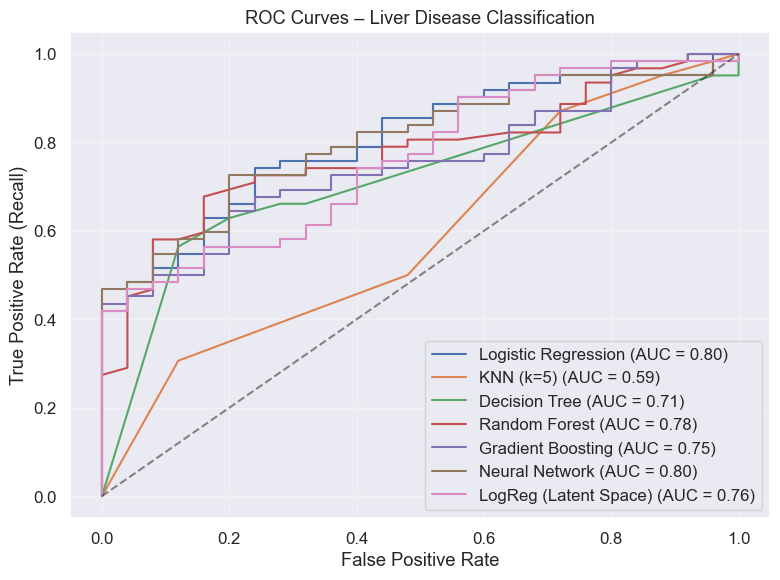

In [19]:
plt.figure(figsize=(8, 6))

for name, info in models_curves.items():
    plt.plot(info["fpr"], info["tpr"], label=f"{name} (AUC = {info['roc_auc']:.2f})")

# Diagonal line = random classifier
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves – Liver Disease Classification")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## Combined Precision–Recall Curves

"""
The PR curve is more informative for imbalanced datasets.
Higher PR-AUC values indicate better precision at high recall levels.
"""

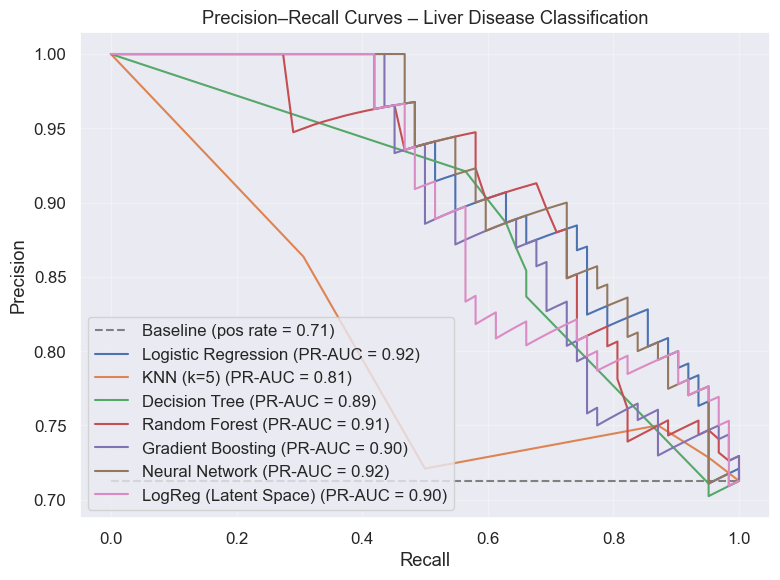

In [20]:
plt.figure(figsize=(8, 6))

# Baseline = positive class prevalence
positive_rate = y_test.mean()
plt.hlines(positive_rate, 0, 1, colors="gray", linestyles="dashed", label=f"Baseline (pos rate = {positive_rate:.2f})")

for name, info in models_curves.items():
    plt.plot(info["recall"], info["precision"], label=f"{name} (PR-AUC = {info['pr_auc']:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Liver Disease Classification")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
## Summary Table of Metrics

"""
This table consolidates all model metrics for easier comparison.
It will be used in the technique report and slide deck.
"""

In [21]:
import pandas as pd

results_list = [
    log_reg_results,
    knn_results,
    dt_results,
    rf_results,
    gb_results,
    nn_results,
    log_reg_latent_results
]

results_df = pd.DataFrame(results_list)
results_df

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Logistic Regression,0.735632,0.746835,0.951613,0.836879,0.802581,0.918128
1,KNN (k=5),0.701149,0.750000,0.870968,0.805970,0.590968,0.806213
2,Decision Tree (max_depth=5),0.689655,0.710843,0.951613,0.813793,0.713871,0.888847
3,Random Forest,0.735632,0.746835,0.951613,0.836879,0.775161,0.907554
4,Gradient Boosting,0.724138,0.743590,0.935484,0.828571,0.750968,0.899790
5,Neural Network,0.735632,0.746835,0.951613,0.836879,0.804516,0.921089
6,Logistic Regression (Autoencoder Latent Space),0.747126,0.743902,0.983871,0.847222,0.762581,0.900296


In [ ]:
## Confusion Matrices

"""
Confusion matrices show false positives and false negatives clearly.
This is important for understanding the types of errors each model makes.
"""

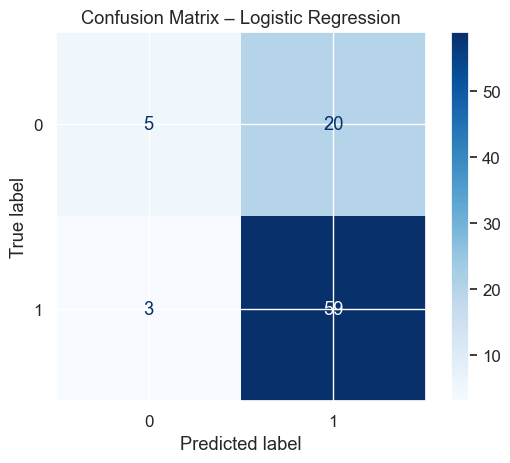

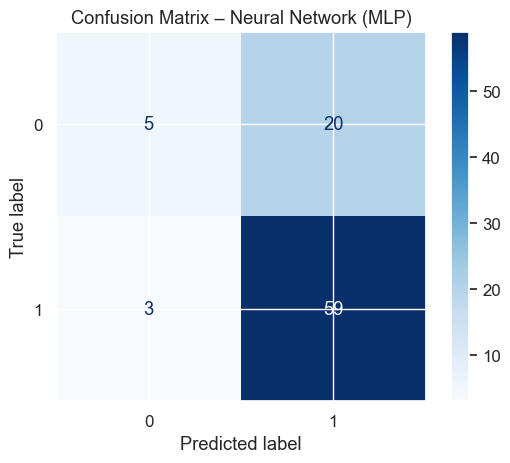

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='d', cmap='Blues')
    plt.title(title)
    plt.show()

# Logistic Regression Confusion Matrix
y_pred_lr = log_reg.predict(X_test_scaled)
plot_conf_matrix(y_test, y_pred_lr, "Confusion Matrix – Logistic Regression")

# Neural Network Confusion Matrix
plot_conf_matrix(y_test, y_pred_nn, "Confusion Matrix – Neural Network (MLP)")

In [ ]:
## PCA Visualization

"""
A linear dimensionality reduction technique that projects high-dimensional data into 2D.
Useful for understanding broad structure, though limited for complex datasets.
"""

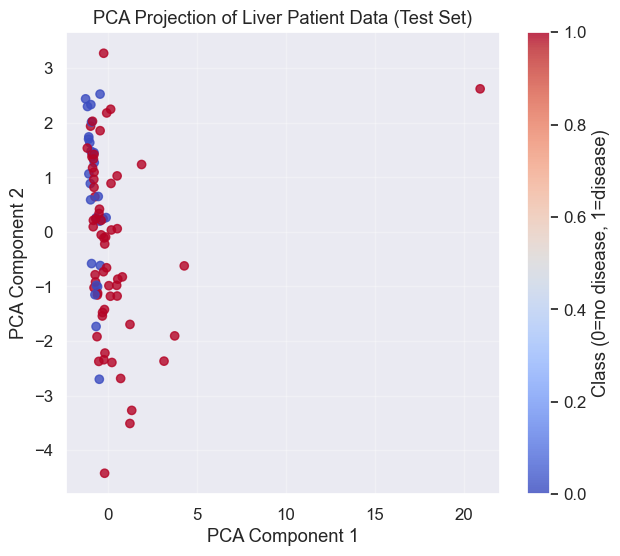

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.8)
plt.title("PCA Projection of Liver Patient Data (Test Set)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Class (0=no disease, 1=disease)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
## Autoencoder Latent Space Visualization

"""
The latent space reveals nonlinear structure learned by the autoencoder.
Helpful for interpreting how the AE groups data without supervision.
""" 

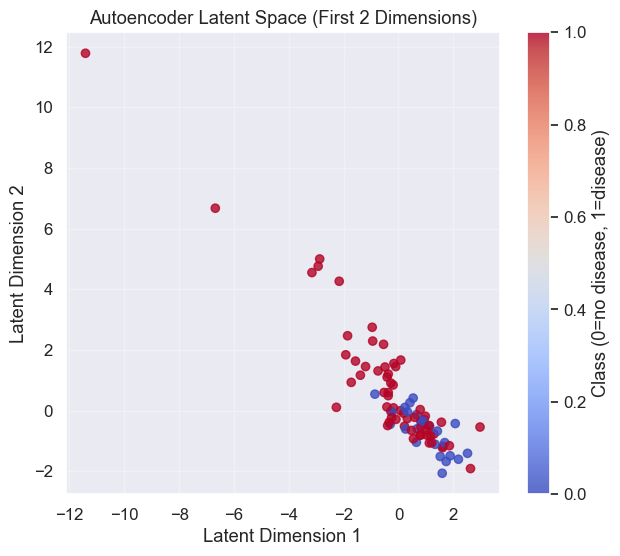

In [24]:
# Use the latent features extracted earlier: X_test_latent (shape: 87 x 3)
# Visualize the first two latent dimensions

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_test_latent[:, 0],
    X_test_latent[:, 1],
    c=y_test,
    cmap='coolwarm',
    alpha=0.8
)

plt.title("Autoencoder Latent Space (First 2 Dimensions)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(scatter, label="Class (0=no disease, 1=disease)")
plt.grid(alpha=0.3)
plt.show()